# University of Minnesota 
## Program for Clinical AI (P4AI) in the Center for Learning Health System Sciences

## NLP Task - Analyst Position
### Kate Weber
`kgweber@umich.edu`

# Task Approach

I see this task as a question of detecting the presence or absence of semantic information from one data input in a longer data input. The biomedical writing is extremely complex, with arcane syntax and vocabulary. While preparing my approach, I read the [SemRep](https://link.springer.com/article/10.1186/s12859-020-3517-7) paper so see how the original algorithm worked so I didn't apply methods that amplified its weaknesses.

I reviewed a number of other papers such as [Verma and Muralikrishna](https://ieeexplore.ieee.org/abstract/document/9198445) and [Chen et al.](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1044-0) for ideas on my approach but found that most of them were interested in whether Sentence A meant _the same thing_ as Sentence B, not whether A _was contained_ within B.

The authors of SemRep performed semantic analysis of the content and explicitly linked it to sources of biomedical knowledge. I decided to apply a transformer model to the problem, choosing one that already had been exposed to large quantities of biomedical information. [BioClinicalBERT](https://arxiv.org/abs/1904.03323) has worked well for me on tasks involving parsing clinical notes, so I decided to bring it to the task.

## Technical Approach

* **Coding Platform** I chose Python for its familiarity and access to some great deep learning APIs. (If this were purely a statistical analysis, I might have opted for R, depending on the audience for the outcome)
* **Deep Learning Stack** I opted for Keras because it produces very readable code and is quick to put together and re-organize. This algorithm needs optimization (a lot), so if we were talking about taking it to a more robust state, I'd rewrite in TensorFlow.
* **Compute** Linux with a NVIDIA Tesla V100 GPU, CUDA 12.1. There are probably artifacts of bizarre NVIDIA/Tensorflow/CUDA/Linux-headers dependency errors in this notebook - I chose to work around them, but again: for production, this would need to be resolved.

## Modeling Approach
Since Bert is doing the bulk of the semantic work for me, the core questions were really how to present the information to a model for inference. I chose to trial two architectures:
* A **single input** in which I concatenated the predication with the sentence and let Bert sort it out; and
* **Two inputs** - one the predication and one the sentence - with an extra hidden layer for the longer sentence. I tried this on the theory that the sentence might require more transformation before it could be evaluated against the predication input.

## Data Prep

I did some very basic exploratory analysis before preparing the data in `data_prep.ipynb`. I cleaned redundant spaces from the `SENTENCE` variable and created a new column called `predication` in which I merged the subject, predicate, and object into a single mini-sentence.  I also created a new column called `concatenated` in which I concatenated the new `predication`, a `[SEP]` token, and the cleaned `sentence`.

Each of these columns - `sentence`, `predication`, and `concatenated` - was tokenized by the BertTokenizer and stored in a dictionary. I padded the sentences and concatenated columns out to 250 tokens. Some of them are much longer, but I was running into memory issues, so cut it to a value that still contained the entirety of the overwhelming majority of sentences. The predications were padded to 32 tokens.

I took a test split of 20% of the rows and created a train split of the remaining 80%. Validation during training took another 20% from the train split, leaving the test set solely for evaluation after training.  The dataset was stored in a `pickle` file for re-use so that all training and evaluation work was definitively running over the same data.

## Training and Evaluation

After early experiments to prove the concept, I used [Weights and Balances](https://api.wandb.ai/links/dlhs_rau/t5z7sl3u) to track experiments and automate my hyperparameter search.  The link will take you to a report showing the accuracy and validation-loss curves for selected runs. I very quickly learned that the two-input model (when I could get it to run) produced results no better than the concatenated model. It frequently ran out of memory and I abandoned it to avoid a nastygram from the cluster's manager. I manipulated batch size, learning rate, the number of epochs, and dropout size as I tuned. 

The models fell into three basic groups:
* Models that overtrained instantly: without dropout, the models quickly memorized this dataset.
* Models that never trained at all. Although some dropout was helpful, if it went too high, or learning rate was wrong, the model just sat on the 0.50 accuracy line and flipped a coin every time
* Models that were _just right_: a very limited number. I learned to push my batch size up as high as the GPU would take (8, if the stars aligned just so) and hold dropout around .40 to slow the learning process to a manageable rate. The selected model (`resilient-music-93`) was generated with hyperparameters identified by run `helpful-cosmos-99` after the sweeps concluded.

(Jump to [Evaluation](#evaluation-section) for the results)


# Load Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import classification_report, confusion_matrix

from keras.layers import Dense, Input, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam

import wandb
from wandb.keras import WandbMetricsLogger

from transformers import TFBertModel

We bring in the prepared data
(see [data_prep.ipynb](data_prep.ipynb) for the prep tasks)

In [4]:
with open('data/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

for k, v in dataset.items():
    print(k, v.keys())

sentence dict_keys(['text', 'max_length', 'encoded', 'test', 'train'])
predication dict_keys(['text', 'max_length', 'encoded', 'test', 'train'])
concatenated dict_keys(['text', 'max_length', 'encoded', 'test', 'train'])
predicate dict_keys(['text', 'test', 'train'])
label dict_keys(['text', 'test', 'train'])


# Training Code

The code below is designed so it can be run once with a given configuration, or as part of a sweep. Lines that actually execute the sweep have been commented out to prevent an accident - as has the code that saves a model.

## Train Function

This can be run once or take inputs from a hyperparameter sweep. This model architecture is for the single-input, concatenated model. 

In [ ]:
bmodel = TFBertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

def train_model():
    # these are config values that came from wandb sweep passes
    config_defaults = {
        "model_name": "concatenated_model",
        "dropout": 0.43,
        "learning_rate": 0.000030,
        "epsilon": 1e-08,
        "loss": "binary_crossentropy",
        "metric": ["accuracy"],
        "epoch": 6,
        "batch_size": 8,
        "validation_split": 0.2,
    }

    wandb.init(
        project="uminn",
        config=config_defaults
    )

    train_x = dataset['concatenated']['train']
    train_y = dataset['label']['train']

    # define the model

    inputs = Input(shape=(250,), dtype='int32')
    bert_output = bmodel(inputs)
    bert_output = bert_output[1]
    dropout = Dropout(wandb.config.dropout)(bert_output)
    dense = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=dense)

    opt = Adam(learning_rate=wandb.config.learning_rate,
               epsilon=wandb.config.epsilon)

    model.compile(loss=wandb.config.loss,
                         optimizer=opt,
                         metrics=['accuracy'])

    model.fit(train_x,
                     train_y,
                     epochs=wandb.config.epoch,
                     validation_split=wandb.config.validation_split,
                     callbacks=[WandbMetricsLogger()])

    return model

The code I was using for the (abandoned) two-input model is in the far-less-talkative workbook in `./extras/two_inputs.ipynb`. Its heart is this architecture:


```python
train_x = (dataset['predication']['train'], dataset['sentence']['train'])
train_y = dataset['label']['train']

input_preds = Input(shape=(32,), dtype='int32')
input_sents = Input(shape=(250,), dtype='int32')
preds_bert_output = bmodel(input_preds)
sents_bert_output = bmodel(input_sents)
preds_bert_output = preds_bert_output[1]
sents_bert_output = sents_bert_output[1]
hidden_sents_1 = Dense(32, activation='relu')(sents_bert_output)
dropout_sents_1 = Dropout(wandb.config.dropout)(hidden_sents_1)
concat = Concatenate()([preds_bert_output, hidden_sents_1])
dense = Dense(1, activation='sigmoid')(concat)
two_input_model = Model(inputs=[input_preds, input_sents], outputs=dense)
```

### Training Curves
These plots are excerpted from the report at [Weights and Balances](https://api.wandb.ai/links/dlhs_rau/t5z7sl3u):

![Images of validation-loss and accuracy curves](extras/training-val-curves.png)


In [ ]:
# just do one with given hyperparameters

model_file_name = 'concat_resilient_music.keras'
# 
trained_model = train_model()
# commented out for safety
# trained_model.save(f'models/{model_file_name}')
wandb.finish()

## Sweep Configuration

In [ ]:
# Or do a hyperparameter sweep to find some good settings

# sweep_config = {
#     'method': 'bayes',
#     'name': 'umn-concatenation',
#     'metric': {
#         'name': 'epoch/val_loss',
#         'goal': 'minimize'
#     },
#     'parameters': {
#         "dropout": {'min': 0.20, 'max': 0.80},
#         "learning_rate": {'values': [5e-5, 3e-5, 2e-5]},
#         "epoch": {'min': 6, 'max': 10},
#         "batch_size": {'values': [2, 4, 6, 8]}
#     },
# }

# sweep_id = wandb.sweep(sweep_config, project="uminn")
# wandb.agent(sweep_id, train_model, count=10)

<a id='evaluation-section'></a>

# Evaluation

The shortest-version: On our test set, the model I chose has
* **Precision**: 0.720446
* **Recall**: 0.720000
* **F1 Score**: 0.718635

This was the closest I could get with this approach, and even so, these test-set results are much poorer than what we get from the training set. I am looking forward to talking to you to get a reality check on how this performance actually rates. 

In [3]:
# load a model from disk
concat_model = load_model('models/concat_resilient_music.keras', custom_objects={"TFBertModel": TFBertModel})

test_pred = concat_model.predict(dataset['concatenated']['test'])
train_pred = concat_model.predict(dataset['concatenated']['train'])

concat_model.summary()

75/75 [==============================] - 21s 273ms/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   108310272 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 250, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
     

## Subsetting the Data

I was curious whether certain predicates performed better than others - whether some verbs are more difficult to generalize than others, and whether the imbalance between the classes led the algorithm to ignore one kind of predicate in favour of the others. So I ran the evaluation over each subset of the data.

On the whole, it appears that performance is balanced across the classes of predicates. The order of performance between the classes is different between train and test, leading me to believe that the differences may just be noise.



In [0]:
predictions = {'test': pd.DataFrame({'y_pred': test_pred.round().flatten(), 
                                            'label': dataset['label']['test'],
                                            'predicate': dataset['predicate']['test'],
                                            }),
               'train': pd.DataFrame({'y_pred': train_pred.round().flatten(), 
                                             'label': dataset['label']['train'],
                                             'predicate': dataset['predicate']['train'],
                                             })
               }
test_class_df = pd.DataFrame(classification_report(predictions['test']['label'], 
                                                   predictions['test']['y_pred'], 
                                                   output_dict=True))
test_class_df['dataset'] = 'test'
train_class_df = pd.DataFrame(classification_report(predictions['train']['label'], 
                                                   predictions['train']['y_pred'], 
                                                   output_dict=True))
train_class_df['dataset'] = 'train'
class_df = pd.concat([test_class_df, train_class_df], axis=0)
class_df['stratum'] = 'full_dataset'
class_df = class_df.reset_index().rename(columns={'index': 'metric'})

conf_mxes = {'test': {'full_dataset': confusion_matrix(predictions['test']['label'], predictions['test']['y_pred'])},
             'train': {'full_dataset': confusion_matrix(predictions['train']['label'],  predictions['train']['y_pred'])}
             }

# subset by predicate
for ds in ['train', 'test']:
    for stratum in ['INHIBITS', 'INTERACTS_WITH', 'STIMULATES']:
        df = predictions[ds]
        df = df.loc[df.predicate == stratum]
        strat_df = pd.DataFrame(classification_report(df.label, df.y_pred, output_dict=True))
        strat_df['stratum'] = stratum
        strat_df['dataset'] = ds
        strat_df = strat_df.reset_index().rename(columns={'index':'metric'})
        class_df = pd.concat([class_df, strat_df], axis=0)
        
        conf_mxes[ds][stratum] = confusion_matrix(df.label, df.y_pred)


## Classification Report

In [8]:
class_df.loc[class_df['metric']!='support', ['metric', 'weighted avg', 'dataset', 'stratum']].pivot(index = ['dataset', 'stratum'], columns='metric', values='weighted avg')

metric                  f1-score  precision    recall
dataset stratum                                      
test    INHIBITS        0.713109   0.713126  0.713178
        INTERACTS_WITH  0.704751   0.707434  0.708683
        STIMULATES      0.763765   0.765429  0.763158
        full_dataset    0.718635   0.720446  0.720000
train   INHIBITS        0.907502   0.908794  0.907368
        INTERACTS_WITH  0.936437   0.937777  0.936798
        STIMULATES      0.942051   0.942057  0.942116
        full_dataset    0.932018   0.932191  0.932083

## Confusion Matrices

Let's have a look at how the whole dataset (and subsets by predicate) performed with this model. 

Text(0.5, 1.05, 'Confusion Matrices for Each Subset of the Data')

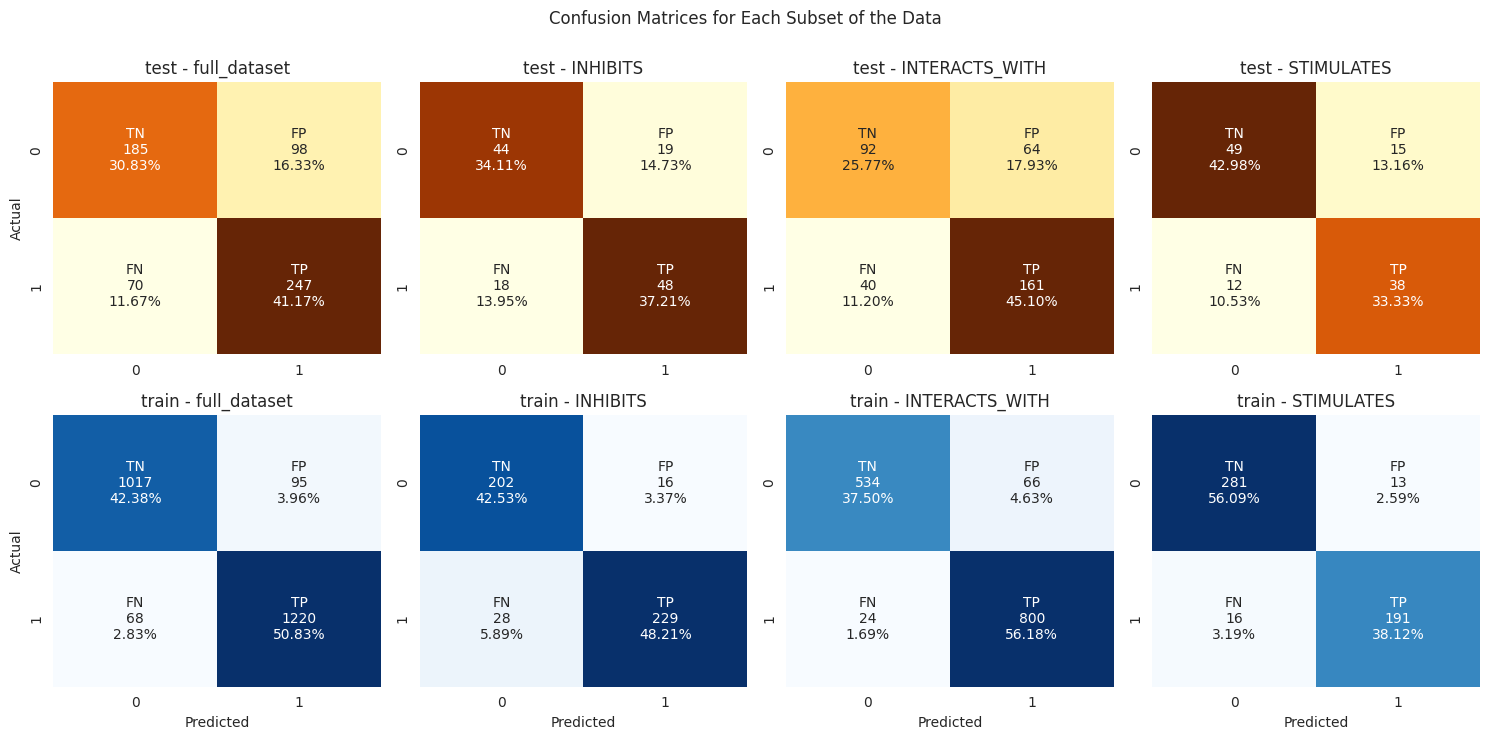

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
group_names = ['TN', 'FP', 'FN', 'TP']

cmap = {'train': 'Blues', 'test': 'YlOrBr'}
for i, ds in enumerate(conf_mxes):
    for j, stratum in enumerate(conf_mxes[ds]):
        group_counts = ['{0:0.0f}'.format(value) for value in conf_mxes[ds][stratum].flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in conf_mxes[ds][stratum].flatten()/np.sum(conf_mxes[ds][stratum])]
        labels = [f'{nm}\n{ct}\n{pct}' for nm, ct, pct in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(conf_mxes[ds][stratum], annot=labels, cmap=cmap[ds], fmt='', cbar=False, ax=axs[i,j])
        axs[i,j].set_title(f'{ds} - {stratum}')
        if i==1:
            axs[i,j].set_xlabel('Predicted')
        if j==0:
            axs[i,j].set_ylabel('Actual')
        
plt.tight_layout()
plt.suptitle('Confusion Matrices for Each Subset of the Data', y=1.05)

Test doesn't do as well as Train (no surprise). For specific predicates, we see that the STIMULATES predicate generally performed better than the other predicates. When we look back at the distribution of labels in the original dataset, we see that it had a smaller fraction of the dataset to work with, but more negative examples - and is the only predicate for which TRUE NEGATIVE outperformed TRUE POSITIVE. I would like to learn more about the dataset and its context to learn why this might be the case, above and beyond pure numbers.

![image](extras/data_prep_predicate_heatmap.png)

## F1-Score Comparison

Let's look at how F1 scores in Test and Train compare across the predicates.  

Again, we see the wide gap between Test and Train, and modestly-better Test performance for STIMULATES.

Text(0.5, 1.05, 'Model performance subsetted by predicate and the train/test split')

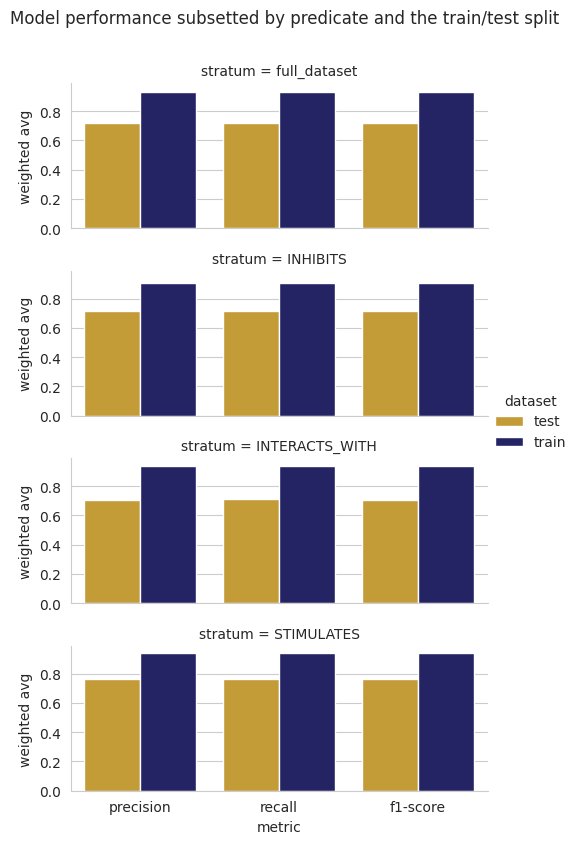

In [10]:
sns.set_style('whitegrid')
palette={'test': 'goldenrod', 'train': 'midnightblue'}
oaplot=sns.catplot(class_df.loc[class_df['metric'] != 'support'], 
            x='metric', y='weighted avg',
            # col='dataset', 
                   row='stratum', 
            kind='bar',  hue='dataset', palette=palette,
            height = 2, aspect = 2.5)
oaplot.fig.suptitle("Model performance subsetted by predicate and the train/test split", y=1.05)

# Limitations and Next Steps

## Limitations
In order to be sure I delivered a sound product on short notice, I confined myself to a single overall approach - that of using BioClinicalBERT to cope with the semantic content in this exercise. That decision brought hardware constraints to the types of architecture I was able to explore.  Additionally, by choosing Keras, I was able to quickly prototype and experiment, but at the cost of customizability. I would be very interested in exploring whether all the layers of the BERT model are needed in the network, or whether we could slim it down.

The dataset itself, with only 3000 examples, is a constraint on how well a neural network is able to perform without quickly overtraining. I overcame this in one project with a semi-supervised learning approach that took advantage of sub-labels in annotated text: it might be possible to do a similar job by definitively labelling all the negative examples in the dataset if we were to extract each object-verb-subject triplet from the sentences.

## Possible Future Work

If I were to continue on with this work, I would look at a few alternatives:
* I would look for a more compact transformer and look for ways to optimize it with a more customized model
* Generally speaking, I would look more closely at SemRep's parsing methods and search for improvements; I would then turn attention to other ways to examine the structure and semantics of the sentence to see whether there is an opportunity to compare the labeled predication with more of the sentence's content
* I would consider a semi-supervised approach of extracting as many triplets as possible from the sentence and then having a model learn from our known-negative cases. When that is complete, we could put it to work looking for positive cases (which can't be mapped from the dataset as it exists because we don't know which triplet in the predication actually matched a triplet in the sentence) 
* Finally, I very much want to attempt a completely different approach with graph algorithms, examining whether we can generalize the predicate verbs well enough to allow shallow parsing to generate a document tree and then ask the algorithm to determine whether the predication in hand is a subgraph of the larger document's tree. I think I would explore whether it would be fruitful to parse a full `spaCy` document tree or do shallow parsing to obtain this graph. This paper by [Le, Can, and Collier](https://jbiomedsem.biomedcentral.com/articles/10.1186/s13326-022-00267-3) has an approach of walking a dependency tree to search for paths between nouns that I would like to explore.